<a href="https://colab.research.google.com/github/AnirudhJM24/tea-diseases/blob/main/lakir.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
from keras.backend import dropout
from keras.layers.normalization.batch_normalization import BatchNormalization

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [19]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3
EPOCHS=50

In [20]:
class dataset:

  def load_data(self, path):

    self.dataset = tf.keras.preprocessing.image_dataset_from_directory(
    path,
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
    )

    self.class_names = self.dataset.class_names

    print(self.class_names)

    return self.dataset,self.class_names
  
  def split_data(self,ds, train_split=0.7, val_split=0.1, test_split=0.2, shuffle=True, shuffle_size=10000):

  
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
  
  def augment_data(self, train_data):
    
    data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    ])

    train_data = train_data.map(
    lambda x, y: (data_augmentation(x, training=True), y)
    ).prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_data

  def visualize(self,data_set):
      plt.figure(figsize=(10, 10))
      for image_batch, labels_batch in data_set.take(1):
          for i in range(12):
              ax = plt.subplot(3, 4, i + 1)
              plt.imshow(image_batch[i].numpy().astype("uint8"))
              plt.title(self.class_names[labels_batch[i]])
              plt.axis("off")




In [21]:
ds = dataset() 

In [22]:
data_set, class_names = ds.load_data("/content/drive/MyDrive/lakir/tea sickness dataset") #add path to dataset

Found 884 files belonging to 8 classes.
['Anthracnose', 'algal leaf', 'bird eye spot', 'brown blight', 'gray light', 'healthy', 'red leaf spot', 'white spot']


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [23]:
train_ds, val_ds, test_ds = ds.split_data(data_set)

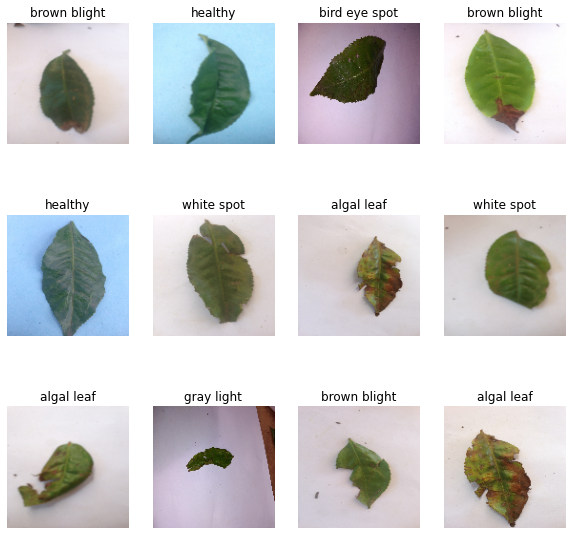

In [24]:
ds.visualize(train_ds)

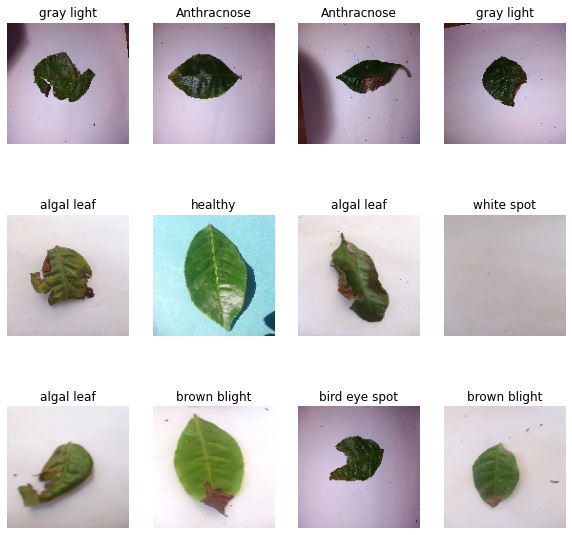

In [25]:
ds.visualize(test_ds)

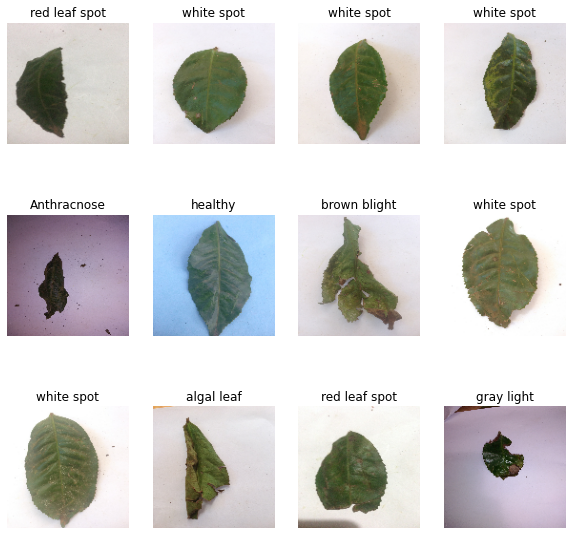

In [26]:
ds.visualize(val_ds)

In [27]:
train_ds = ds.augment_data(train_ds)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


In [55]:

class classifier:

  def create_model(self):

    n_classes = 8

    input_shape = ( None ,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

    model = keras.models.Sequential([
         
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE), #preprocessing the input data
    layers.Rescaling(1./255), #normalizing the data
    
    
    # Cropping Image to focus more on the leaf

    layers.Cropping2D(cropping=((int(IMAGE_SIZE*0.12), int(IMAGE_SIZE*0.12)), (int(IMAGE_SIZE*0.12), int(IMAGE_SIZE*0.12)))),

    # first layer is Conv 16 ->BN->Maxpool
    layers.Conv2D(16, kernel_size = (3,3), activation='relu', input_shape=(int(IMAGE_SIZE*0.88), int(IMAGE_SIZE*0.88),3),padding='same'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),


    # (CONV 32 => RELU)  => POOL
    layers.Conv2D(32,  kernel_size = (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu',padding='same'),
    layers.MaxPooling2D((2,2)),
    layers.BatchNormalization(),
    layers.Dropout(0.25),
    #fully connected layers
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
    ])

    model.build(input_shape=input_shape)

    model.compile(  optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

    model.summary()

    return model

  def train_cls(self,model,epochs):

    

    self.historyhistory = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=epochs,
    )
    

  def history(self):
    acc = self.history.history['accuracy']
    val_acc = self.history.history['val_accuracy']

    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(range(EPOCHS), acc, label='Training Accuracy')
    plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(range(EPOCHS), loss, label='Training Loss')
    plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

  def evaluate(self, model, test_data):

    scores = model.evaluate(test_data)
 
  def predict(self, model, image):

    img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
  
  def run_inference(self, model, test_data):
    plt.figure(figsize=(15, 15))
    for images, labels in test_ds.take(1):
      for i in range(9):
          ax = plt.subplot(3, 3, i + 1)
          plt.imshow(images[i].numpy().astype("uint8"))
        
          predicted_class, confidence = self.predict(model, images[i])
          actual_class = class_names[labels[i]] 
        
          plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
          plt.axis("off")




Due to the small size of the dataset, the above architecture was made such that the number of parameters are minimized and the features extracted are maximized at the same time so as to avoid overfitting as much as possible

In [56]:
cls = classifier()
model = cls.create_model()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_13 (Resizing)      (None, 128, 128, 3)       0         
                                                                 
 rescaling_13 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 cropping2d_13 (Cropping2D)  (None, 98, 98, 3)         0         
                                                                 
 conv2d_57 (Conv2D)          (None, 98, 98, 16)        448       
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 49, 49, 16)       0         
 g2D)                                                            
                                                                 
 batch_normalization_57 (Bat  (None, 49, 49, 16)       64        
 chNormalization)                                    

In [58]:
cls.train_cls(model, 50) # pass model and number of epochs as parameters

Epoch 1/50
19/19 [==============================] - 36s 1s/step - loss: 0.9845 - accuracy: 0.5789 - val_loss: 2.4295 - val_accuracy: 0.1406
Epoch 2/50
19/19 [==============================] - 36s 1s/step - loss: 0.9465 - accuracy: 0.5872 - val_loss: 3.3274 - val_accuracy: 0.0781
Epoch 3/50
19/19 [==============================] - 35s 1s/step - loss: 0.7544 - accuracy: 0.6946 - val_loss: 3.6089 - val_accuracy: 0.1562
Epoch 4/50
19/19 [==============================] - 37s 1s/step - loss: 0.7081 - accuracy: 0.6924 - val_loss: 3.3830 - val_accuracy: 0.1875
Epoch 5/50
19/19 [==============================] - 35s 1s/step - loss: 0.7472 - accuracy: 0.6728 - val_loss: 4.7975 - val_accuracy: 0.0781
Epoch 6/50
19/19 [==============================] - 36s 1s/step - loss: 0.7500 - accuracy: 0.6711 - val_loss: 3.8220 - val_accuracy: 0.2031
Epoch 7/50
19/19 [==============================] - 39s 1s/step - loss: 0.6301 - accuracy: 0.7451 - val_loss: 3.4554 - val_accuracy: 0.1562
Epoch 8/50
19/19 [==

In [59]:
cls.evaluate(model, test_ds) #pass model and test dataset as parameters

7/7 [==============================] - 17s 19ms/step - loss: 1.4733 - accuracy: 0.6429


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


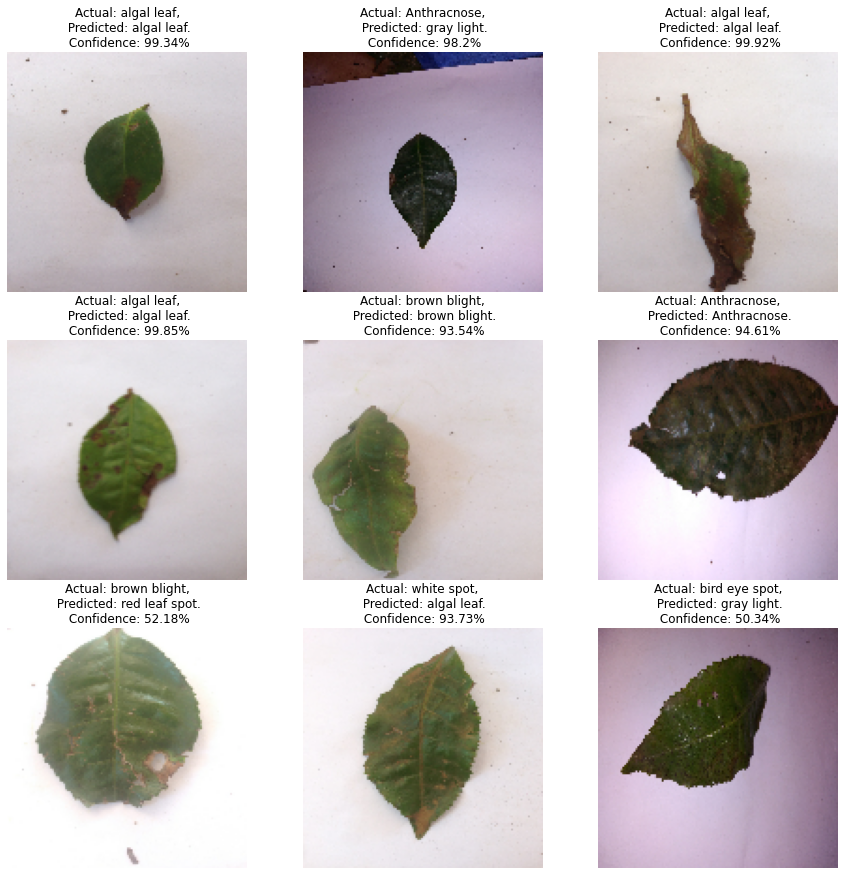

In [60]:
cls.run_inference(model, test_ds) #pass model and test dataset as parameters